# Create Fake countries

In this notebook we create some artificial countries by combining long averages
of realized demand with long averages of capacities factors for renewables.

## Packages and options

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt

In [2]:
fn_demand = "../data/renewables_with_load.parquet"
fn_renewable = "../data/renewables_ninja_averages.parquet"

## Functions

In [3]:
def get_average_demand_profile(fn: str, country: str, first_year: int, 
                               last_year: int, base_year:int = 2023) -> pd.DataFrame:
    """Get hourly demand averaged over several year
    
    Args:
        fn: str: path to the file with demand data
        country: str: country code
        first_year: int: first year to include
        last_year: int: last year to include
        base_year: int: year used for new time index
        
    Returns:
        pd.DataFrame: average demand profile
    """
    df = (
            pd.read_parquet(
            fn, 
            filters=[
                ("country", "=", country),
                ("dateTime", ">=", pd.to_datetime(f"{first_year}-01-01 00:00")),
                ("dateTime", "<=", pd.to_datetime(f"{last_year}-12-31 23:00"))
            ],
            columns=["dateTime", "demand"]
            )
        .assign(
            month=lambda df: df["dateTime"].dt.month,
            day=lambda df: df["dateTime"].dt.day,
            hour=lambda df: df["dateTime"].dt.hour,
        )
        # drop leap year days
        .query("not(month == 2 & day == 29)")
        .groupby(["month", "day", "hour"], as_index=False)
        ["demand"]
        .mean()
        .drop(columns=["month", "day", "hour"])
    )
    # assign a new datetime index
    df = df.assign(
            dateTime=pd.date_range(
                start=f"{base_year}/01/01 00:00",
                periods=len(df),
                freq="h"
            )
        )
    return df

def get_normalized_demands(
        fn_data: str, 
        countries: list[str], 
        annual_demand: int,
        first_year: int,
        last_year: int,
        base_year: int = 2023
    ) -> pd.DataFrame:
    """Get demand normalized to a common annual value for several 
    countries. For each country, the profile is derived as the average over
    several years.
    
    Args:
        fn: str: path to the file with demand data
        countries: str: list of country codes
        first_year: int: first year to include
        last_year: int: last year to include
        base_year: int: year used for new time index
    """
    df = pd.DataFrame()
    for country in countries:
        df_ = get_average_demand_profile(
            fn_data, country=country, first_year=first_year, last_year=last_year, 
            base_year=base_year
        ).rename(columns={"demand": country}).set_index("dateTime")
        df = df.join(df_, how="outer")

    # Normalize to given annual demand
    df = df.div(df.sum())*annual_demand
    return df

def get_ninja_profiles(fn: str, countries: list[str], base_year: int = 2023) -> pd.DataFrame:
    """Get renewable profiles for several countries averaged over all
    weather years.
    
    Args:
        fn: str: path to the file with renewable data
        countries: str: list of country codes
        base_year: int: year used for new time index
    """
    df_re = (
        pd.read_parquet(fn)
        .query(f"country in {countries}")
        # drop leap year days
        .query("not(month == 2 & day == 29)")
        # create datetime index
        .assign(
            dateTime=lambda df: ( 
                pd.to_datetime(
                    f"{base_year}/" 
                    + df["month"].astype("str") 
                    + "/" + df["day"].astype("str") 
                    + " " + df["hour"].astype("str") + ":00"
                )
            )
        )  
        .drop(columns=["month", "day", "hour"])
        .pivot_table(index=["dateTime", "country"], columns="resource", values="national")
        # for consistencs with entsoe data, renname pv to solar
        .rename(columns={"pv": "solar"})
    ) 
    return df_re.reset_index()

def get_average_re_shares(fn: str, countries: list[str]) -> pd.DataFrame:
    """Get the average share of wind and solar in total RE generation for
    a set of countries.
    
    Args:
        fn: str: path to the file with renewable data
        countries: str: list of country codes
    """
    df_re = (
        pd.read_parquet(fn, filters=[("country", "in", countries)])
        .assign(
            wind=lambda df: df[["windOffshore", "windOnshore"]].sum(1),
            year=lambda df: df["dateTime"].dt.year
        )
        .groupby(["year"], as_index=False)
        .agg({"wind": "sum", "solar": "sum"})
        .set_index("year")
    )
    df_re = df_re.div(df_re.sum(1), axis=0)
    return df_re

## Explore average demand profiles

In [4]:
first_year = 2016
last_year = 2023
annual_demand = 100

countries = ["DK", "SE", "NO", "FI", 
             "FR", "DE", "PL", "CZ",
             "ES", "PT", "IT", "GR"]

df_dem = get_normalized_demands(
    fn_data=fn_demand, countries=countries, annual_demand=annual_demand, 
    first_year=first_year, last_year=last_year,
)
df_re = get_ninja_profiles(fn=fn_renewable, countries=countries)
df = (
    df_dem.stack().to_frame("demand").reset_index()
    .rename(columns={"level_1": "country"})
    .merge(df_re, on=["dateTime", "country"])
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   dateTime  105120 non-null  datetime64[ns]
 1   country   105120 non-null  object        
 2   demand    105120 non-null  float64       
 3   solar     105120 non-null  float64       
 4   wind      105120 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 4.0+ MB


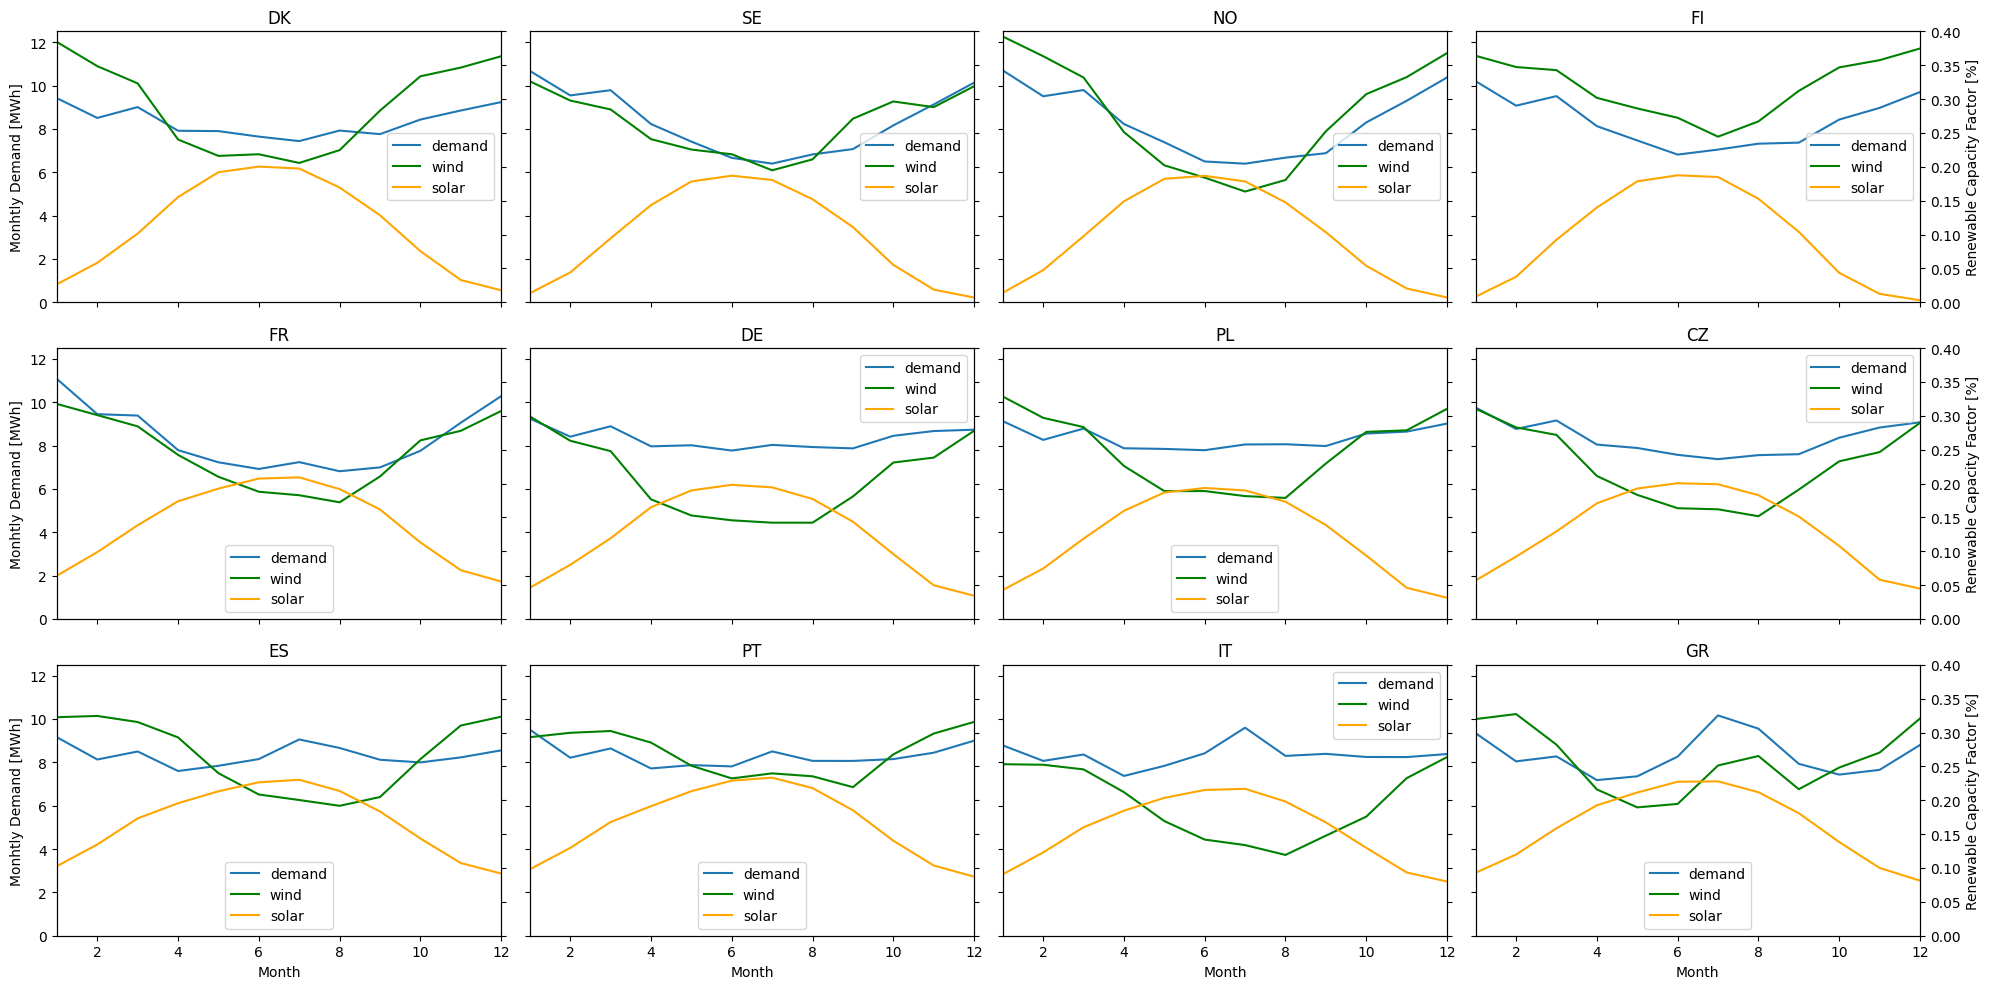

In [5]:
fig, axs = plt.subplots(3,4, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()
axs2 = [ax.twinx() for ax in axs]
df_ = (
    df
    .set_index("dateTime").groupby([lambda x: x.month, "country"])
    .agg({"demand": "sum", "wind": "mean", "solar": "mean"})
    .reset_index(-1)
)

count = 1
for ax, ax2, country in zip(axs, axs2, countries):
    df_p = df_.query(f"country == '{country}'").drop(columns="country")
    df_p["demand"].plot(ax=ax)
    df_p[["wind", "solar"]].plot(ax=ax2, color=["green", "orange"])
    ax.set_xlabel("Month")
    ax.set_ylabel("Monhtly Demand [MWh]")
    ax.set_xlim(1, 12)
    ax.set_ylim(0, annual_demand/12*1.5)
    ax2.set_ylim(0, 0.4)
    # merge the two legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax.set_title(country)
    if count % 4 == 0:
        ax2.set_ylabel("Renewable Capacity Factor [%]")
    else:
        ax2.set_yticklabels([])
    count += 1
plt.tight_layout()
plt.savefig("../figures/average_profiles.pdf", bbox_inches="tight")


## Create dataset

We create the dataset by combining long averages of country profiles with
averages of the capacity factors. Thereby we allow to aggregate renewables and
demand profiles across countries:

In [6]:
def create_artificial_countries(
    fn_demand: str,
    fn_renewable: str,
    countries: dict[str, list[str]],
    renewables: dict[str, list[str]],
    annual_demand: int,
    first_year: int,
    last_year: int,
    base_year: int = 2023,
    year_solar_wind_shares: int | None = 2023,
) -> pd.DataFrame:
    """Create a data frame with demand and renewable data for artificial
    countries by aggregating over the long-averages of countries

    Args:
        fn_demand: str: path to the file with demand data
        fn_renewable: str: path to the file with renewable data
        countries: dict[str, list[str]]: mapping of artificial countries to
            real countries
        renewables: dict[str, list[str]]: mapping of artificial countries to
            real countries
        annual_demand: int: annual demand
        first_year: int: first year to include in demand aggregation
        last_year: int: last year to include in demand aggregation
        base_year: int: year used for new time index
        year_solar_wind_shares: year for observed solar and wind shares in
            total renewable generation to be added to the data frame.
            If None, no shares are added.
    """
    # construct mappings for aggregations
    map_dem = {c: k for k, v in countries.items() for c in v}
    map_ren = {c: k for k, v in renewables.items() for c in v}

    df_dem = (
        get_normalized_demands(
            fn_data=fn_demand, 
            countries=list(map_dem.keys()), 
            annual_demand=annual_demand, 
            first_year=first_year, 
            last_year=last_year,
            base_year=base_year
        )
        .stack().to_frame("demand").reset_index()
        .assign(
            country=lambda df: df["level_1"].map(map_dem)
        )
        .groupby(["dateTime", "country"], as_index=False)
        ["demand"]
        .mean()
    )

    df_re = (
        get_ninja_profiles(fn=fn_renewable, countries=list(map_ren.keys()))
        .assign(
            country=lambda df: df["country"].map(map_ren)
        )
        .groupby(["dateTime", "country"], as_index=False)
        .agg({"wind": "mean", "solar": "mean"})
    )
    df = (
        df_dem.merge(df_re, on=["dateTime"], how="outer")
        .assign(country=lambda df: df["country_x"] + "_" + df["country_y"])
        .drop(columns=["country_x", "country_y"])
    )

    if year_solar_wind_shares is not None:
        lst_shares = []
        for new_c, co in countries.items():
            lst_shares.append(
                get_average_re_shares(fn_demand, co)
                .rename(columns={"wind": "wind_share", "solar": "solar_share"})
                .assign(temp=new_c)
            )
        df_re_shares = pd.concat(lst_shares)

        df = (
            df
            .assign(temp=df.country.str.split("_").str[0])
            .merge(
                df_re_shares.loc[year_solar_wind_shares, :], 
                on="temp",
                how="left"
            )
            .drop(columns=["temp"])
        )
    return df

In [7]:
first_year = 2016
last_year = 2023
annual_demand = 100
base_year = 2023
year_solar_wind_shares = 2023
countries = {
    "mildWinterPeakDE": ["DE"],
    "strongWinterPeakFR": ["FR"],
    "strongSummerPeakGR": ["GR"],
    "mildSummerPeakES": ["ES"],
}

renewables = {
    "central": [ "FR", "DE", "PL", "CZ"],
    "north": ["DK", "SE", "NO", "FI"],
    "south": ["ES", "PT", "IT"] # "GR"
}



df = create_artificial_countries(
    fn_demand=fn_demand,
    fn_renewable=fn_renewable,
    countries=countries,
    renewables=renewables,
    annual_demand=annual_demand,
    first_year=first_year,
    last_year=last_year,
    base_year=base_year,
    year_solar_wind_shares=year_solar_wind_shares
)


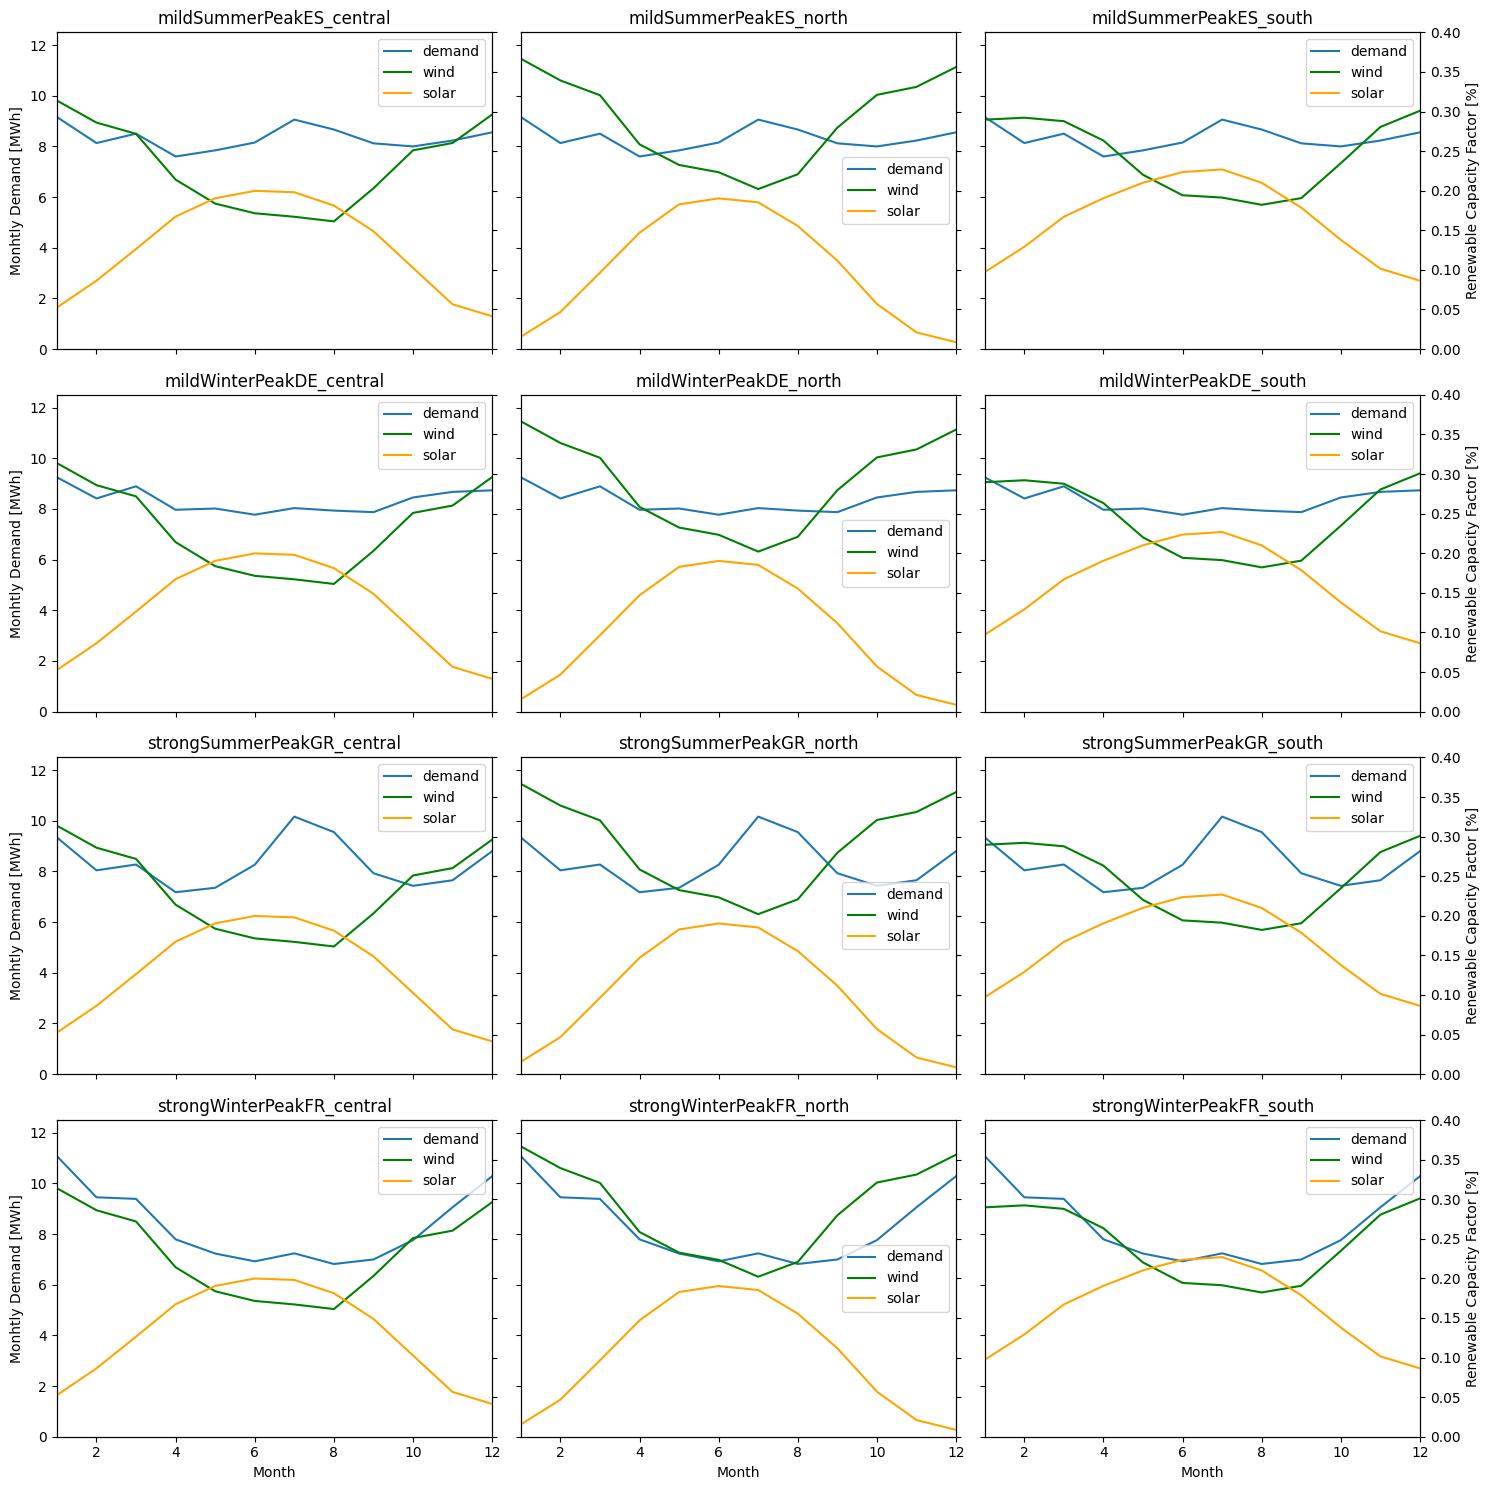

In [8]:
fig, axs = plt.subplots(4,3, figsize=(15, 15), sharex=True, sharey=True)
axs = axs.flatten()
axs2 = [ax.twinx() for ax in axs]
df_ = (
    df
    .set_index("dateTime").groupby([lambda x: x.month, "country"])
    .agg({"demand": "sum", "wind": "mean", "solar": "mean"})
    .reset_index(-1)
)

count = 1
for ax, ax2, country in zip(axs, axs2, df["country"].unique()):
    df_p = df_.query(f"country == '{country}'").drop(columns="country")
    df_p["demand"].plot(ax=ax)
    df_p[["wind", "solar"]].plot(ax=ax2, color=["green", "orange"])
    ax.set_xlabel("Month")
    ax.set_ylabel("Monhtly Demand [MWh]")
    ax.set_xlim(1, 12)
    ax.set_ylim(0, annual_demand/12*1.5)
    ax2.set_ylim(0, 0.4)
    # merge the two legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax.set_title(country)
    if count % 3 == 0:
        ax2.set_ylabel("Renewable Capacity Factor [%]")
    else:
        ax2.set_yticklabels([])
    count += 1
plt.tight_layout()
plt.savefig("../figures/average_profiles_model_countries.pdf", bbox_inches="tight")

In [9]:
df.to_parquet("../data/artificial_countries.parquet", index=False)

In [10]:
df.query("country == 'mildSummerPeakES_south'")

,dateTime,demand,wind,solar,country,wind_share,solar_share
2,2023-01-01 00:00:00,0.008978,0.299140,0.0,mildSummerPeakES_south,0.601681,0.398319
14,2023-01-01 01:00:00,0.008396,0.296747,0.0,mildSummerPeakES_south,0.601681,0.398319
26,2023-01-01 02:00:00,0.007897,0.293924,0.0,mildSummerPeakES_south,0.601681,0.398319
38,2023-01-01 03:00:00,0.007584,0.294493,0.0,mildSummerPeakES_south,0.601681,0.398319
50,2023-01-01 04:00:00,0.007473,0.295113,0.0,mildSummerPeakES_south,0.601681,0.398319
...,...,...,...,...,...,...,...
105062,2023-12-31 19:00:00,0.011904,0.299597,0.0,mildSummerPeakES_south,0.601681,0.398319
105074,2023-12-31 20:00:00,0.011335,0.298838,0.0,mildSummerPeakES_south,0.601681,0.398319
105086,2023-12-31 21:00:00,0.010309,0.295379,0.0,mildSummerPeakES_south,0.601681,0.398319
105098,2023-12-31 22:00:00,0.009719,0.291813,0.0,mildSummerPeakES_south,0.601681,0.398319


In [10]:
df.country.unique()

array(['mildSummerPeakES_central', 'mildSummerPeakES_north',
       'mildSummerPeakES_south', 'mildWinterPeakDE_central',
       'mildWinterPeakDE_north', 'mildWinterPeakDE_south',
       'strongSummerPeakGR_central', 'strongSummerPeakGR_north',
       'strongSummerPeakGR_south', 'strongWinterPeakFR_central',
       'strongWinterPeakFR_north', 'strongWinterPeakFR_south'],
      dtype=object)